# QEC Dual Rail Analysis

In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import json

from slab import AttrDict
from slab.datamanagement import SlabFile
from fitting.fit_display_classes import GeneralFitting
from fitting.fit_display import *
import fitting.fitting as fitter
from scipy.optimize import curve_fit

# -- Plot style ---------------------------------------------------------------
plt.rcParams.update({
    'figure.figsize': [8, 5],
    'font.size': 13,
    'font.family': 'sans-serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.6,
    'legend.frameon': False,
    'legend.fontsize': 11,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
})

# -- Color palette (reuse across all plots) -----------------------------------
COLORS = {
    'mode1': '#4C72B0',    # muted blue
    'mode2': '#DD8452',    # muted orange
    'dual_rail': '#55A868', # muted green
}
alpha_plot = 0.7

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
storage_modes = [1, 2, 3, 4, 6, 7]
dual_rail_modes = [[1, 3], [2, 4], [6, 7]]

# Data Paths

In [4]:
experiment_name = '250119_qec'
base_path = rf'D:\experiments\{experiment_name}'
data_path = os.path.join(base_path, 'data')
expt_objs_path = os.path.join(base_path, 'expt_objs')

print('Data path:', data_path)
print('Expt objects path:', expt_objs_path)

Data path: D:\experiments\250119_qec\data
Expt objects path: D:\experiments\250119_qec\expt_objs


In [5]:
def prev_data(expt_path, filename):
    """Load data and attributes from an HDF5 file."""
    with SlabFile(os.path.join(expt_path, filename)) as a:
        attrs = {key: json.loads(a.attrs[key]) for key in a.attrs}
        temp_data = {key: np.array(a[key]) for key in a}
    return temp_data, attrs

# Load Experiment Data

In [6]:
filename_t2_ramsey = [
    'JOB-20260217-00042_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00043_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00044_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00081_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00086_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00088_CavityModeRamseyExperiment.h5'
]

filename_t2_echo = [
    'JOB-20260217-00091_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00092_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00093_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00094_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00095_CavityModeRamseyExperiment.h5',
    'JOB-20260217-00096_CavityModeRamseyExperiment.h5'
]


filename_dual_rail_ramsey = [
    'JOB-20260214-00202_DualRailRamseyExperiment.h5',
    'JOB-20260214-00212_DualRailRamseyExperiment.h5',
    'JOB-20260215-00004_DualRailRamseyExperiment.h5',
]

filename_dual_rail_echo = [
    'JOB-20260215-00005_DualRailRamseyExperiment.h5',
    'JOB-20260215-00348_DualRailRamseyExperiment.h5',
    'JOB-20260215-00349_DualRailRamseyExperiment.h5',
]

filename_t1_dual_rail = [
    'JOB-20260216-00169_DualRailSandboxExperiment.h5',
    'JOB-20260217-00001_DualRailSandboxExperiment.h5',
    # 'TBD',
]




# Comparing the T2 Echo of the individual modes to the T2 Echo of the dual rail code.

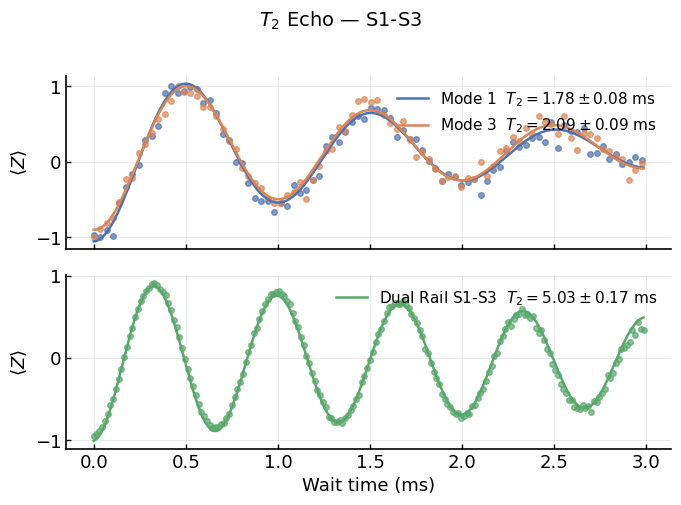

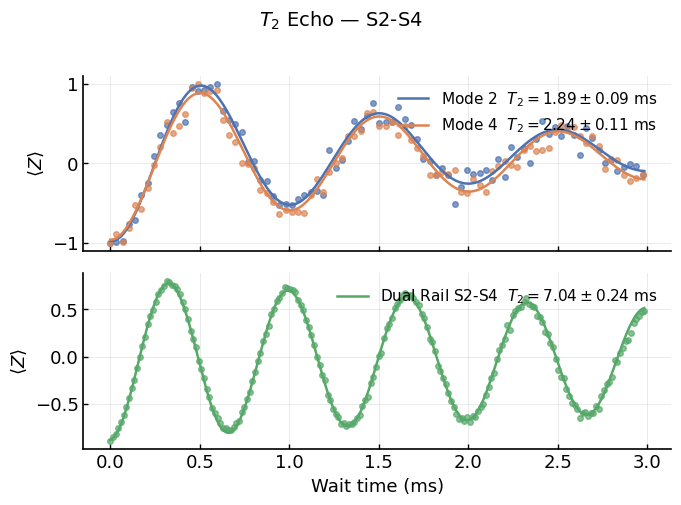

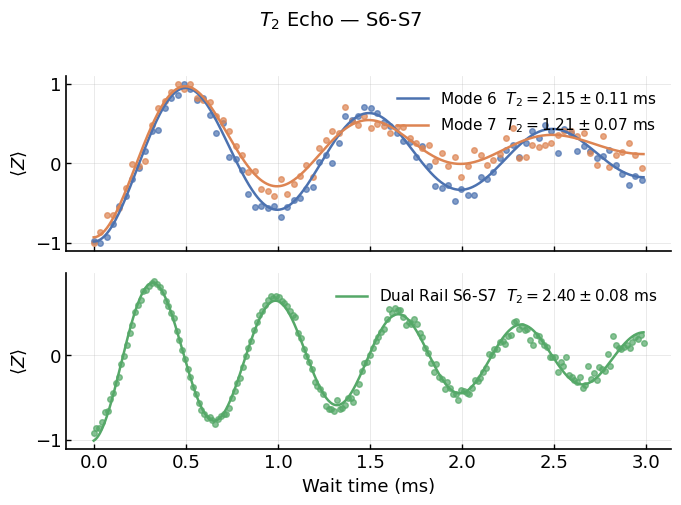

In [7]:
for idx, (mode1, mode2) in enumerate(dual_rail_modes):
    data_mode1, attrs_mode1 = prev_data(data_path, filename_t2_echo[idx*2])
    data_mode2, attrs_mode2 = prev_data(data_path, filename_t2_echo[idx*2+1])
    data_dual_rail, attrs_dual_rail = prev_data(data_path, filename_dual_rail_echo[idx])

    x_mode1 = data_mode1['xpts']
    x_mode2 = data_mode2['xpts']
    x_dual_rail = data_dual_rail['xpts']

    y_mode1 = data_mode1['avgi']
    y_mode2 = data_mode2['avgi']
    y_dr_10_0 = data_dual_rail['p_0_10']
    y_dr_10_1 = data_dual_rail['p_1_10']

    # rescale the mode 1 and mode 2 to be between -1 and 1
    y_mode1 = (y_mode1 - np.min(y_mode1)) / (np.max(y_mode1) - np.min(y_mode1)) * 2 - 1
    y_mode2 = (y_mode2 - np.min(y_mode2)) / (np.max(y_mode2) - np.min(y_mode2)) * 2 - 1

    y_dual_rail = y_dr_10_0 * 2 - 1

    # Refit cavity mode data (6-param decaysin, same as RamseyFitting.analyze)
    pOpt_m1, pCov_m1 = fitter.fitdecaysin(x_mode1, y_mode1)
    pOpt_m2, pCov_m2 = fitter.fitdecaysin(x_mode2, y_mode2)

    # Refit dual rail data (5-param decaysin1, same as DualRailRamseyExperiment.analyze)
    pOpt_dr, pCov_dr = fitter.fitdecaysin(x_dual_rail, y_dual_rail, use_x0=False)

    # Convert T2 values from us to ms
    T2_m1 = pOpt_m1[3] / 1e3
    T2_m1_err = np.sqrt(pCov_m1[3][3]) / 1e3
    T2_m2 = pOpt_m2[3] / 1e3
    T2_m2_err = np.sqrt(pCov_m2[3][3]) / 1e3
    T2_dr = pOpt_dr[3] / 1e3
    T2_dr_err = np.sqrt(pCov_dr[3][3]) / 1e3

    # Plot
    fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

    x_max = min(x_mode1[-1], x_mode2[-1], x_dual_rail[-1])
    idx_mode_1 = np.where(x_mode1 <= x_max)
    idx_mode_2 = np.where(x_mode2 <= x_max)
    idx_dual_rail = np.where(x_dual_rail <= x_max)

    c1, c2, c_dr = COLORS['mode1'], COLORS['mode2'], COLORS['dual_rail']

    # --- Individual modes + fits ---
    ax[0].plot(x_mode1[idx_mode_1] / 1e3, y_mode1[idx_mode_1], 'o',
               color=c1, markersize=4, alpha=alpha_plot)
    ax[0].plot(x_mode2[idx_mode_2] / 1e3, y_mode2[idx_mode_2], 'o',
               color=c2, markersize=4, alpha=alpha_plot)

    x_fit = np.linspace(x_mode1[0], x_max, 500)
    ax[0].plot(x_fit / 1e3, fitter.decaysin(x_fit, *pOpt_m1), '-', color=c1, linewidth=1.8,
               label=f'Mode {mode1}  $T_2 = {T2_m1:.2f} \\pm {T2_m1_err:.2f}$ ms')
    x_fit2 = np.linspace(x_mode2[0], x_max, 500)
    ax[0].plot(x_fit2 / 1e3, fitter.decaysin(x_fit2, *pOpt_m2), '-', color=c2, linewidth=1.8,
               label=f'Mode {mode2}  $T_2 = {T2_m2:.2f} \\pm {T2_m2_err:.2f}$ ms')

    ax[0].legend(loc='upper right')
    ax[0].set_ylabel('$\\langle Z \\rangle$')

    # --- Dual rail + fit ---
    ax[1].plot(x_dual_rail[idx_dual_rail] / 1e3, y_dual_rail[idx_dual_rail], 'o',
               color=c_dr, markersize=4, alpha=alpha_plot)
    x_fit_dr = np.linspace(x_dual_rail[0], x_max, 500)
    ax[1].plot(x_fit_dr / 1e3, fitter.decaysin1(x_fit_dr, *pOpt_dr), '-', color=c_dr, linewidth=1.8,
               label=f'Dual Rail S{mode1}-S{mode2}  $T_2 = {T2_dr:.2f} \\pm {T2_dr_err:.2f}$ ms')

    ax[1].legend(loc='upper right')
    ax[1].set_xlabel('Wait time (ms)')
    ax[1].set_ylabel('$\\langle Z \\rangle$')

    fig.suptitle(f'$T_2$ Echo — S{mode1}-S{mode2}', fontsize=14, y=1.01)
    plt.tight_layout()


# Comparing the T1 of dual rail code to the T1 of the individual modes.

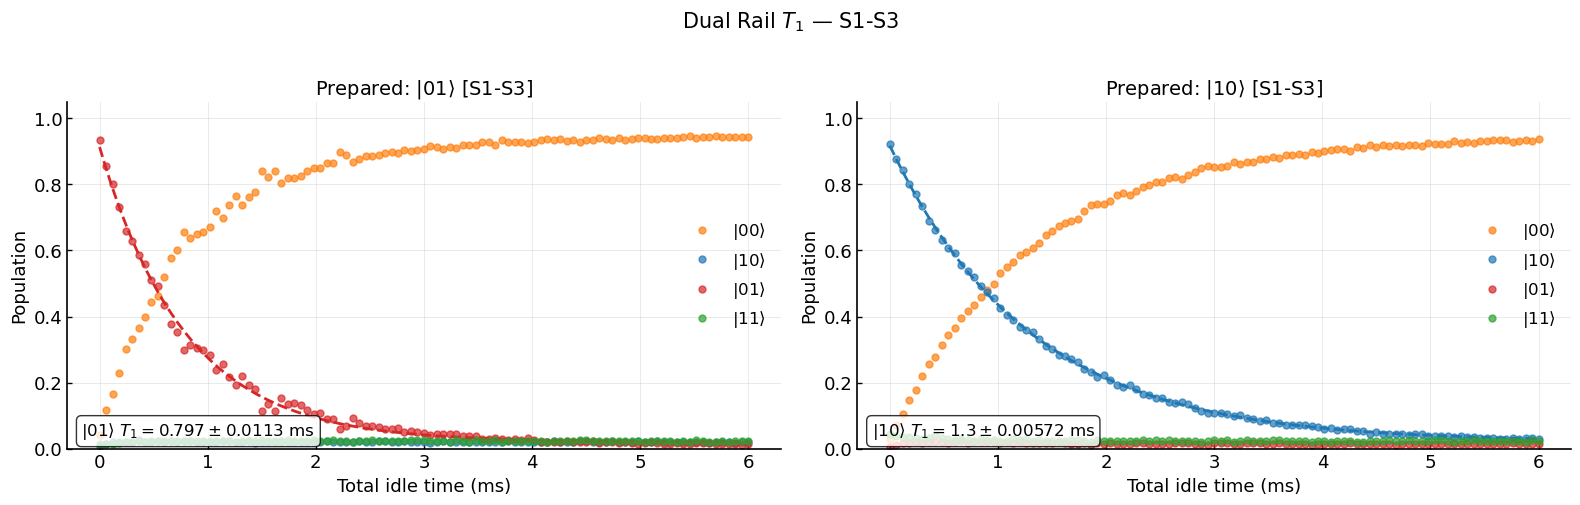

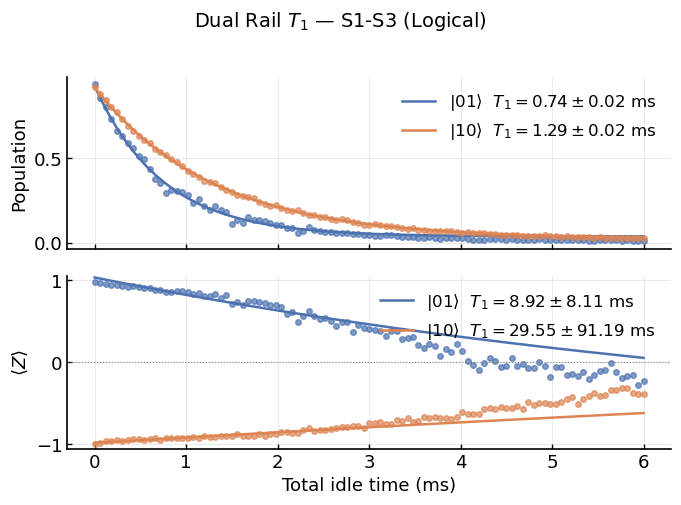

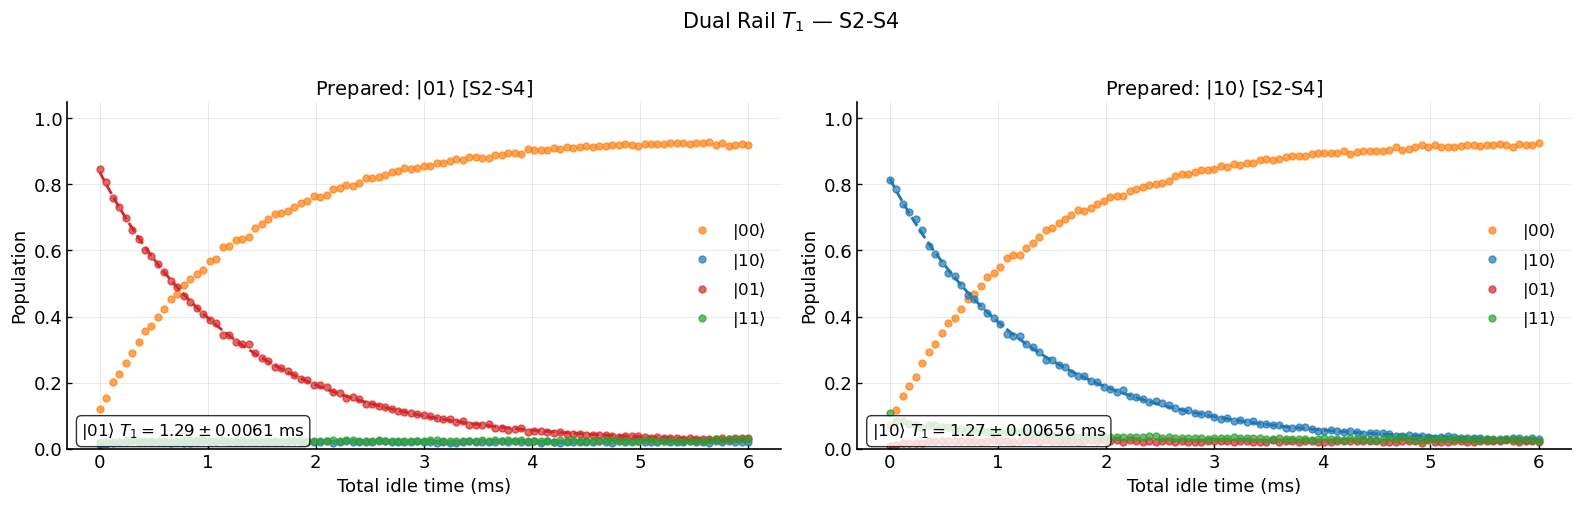

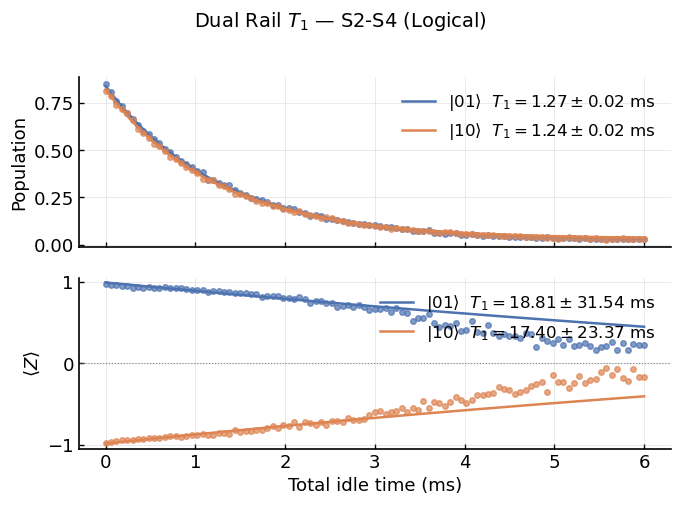

In [18]:

STATE_COLORS = {
    '00': 'tab:orange',
    '10': 'tab:blue',
    '01': 'tab:red',
    '11': 'tab:green',
}
bar_labels = ['00', '10', '01', '11']

for idx, (mode1, mode2) in enumerate(dual_rail_modes[:2]):
    data_dr, attrs_dr = prev_data(data_path, filename_t1_dual_rail[idx])
    stor_pair = f'S{mode1}-S{mode2}'

    # Decode states from bytes if needed
    state_list = data_dr['states']
    if isinstance(state_list, np.ndarray):
        state_list = [s.decode() if isinstance(s, bytes) else s for s in state_list]
    repeat_list = list(data_dr['repeat_counts'])
    wait_list = list(data_dr['wait_times'])

    # --- Summary plot: population vs total idle time ---
    n_states = len(state_list)
    ncols_sum = min(2, n_states)
    nrows_sum = (n_states + ncols_sum - 1) // ncols_sum
    fig, axes = plt.subplots(nrows_sum, ncols_sum,
                             figsize=(8 * ncols_sum, 5 * nrows_sum), squeeze=False)
    axes = axes.flatten()

    for state_idx, prepared_state in enumerate(state_list):
        ax = axes[state_idx]
        fit_texts = []

        for measured_state in bar_labels:
            data_points = []
            for repeat in repeat_list:
                for wait in wait_list:
                    total_time_ms = (repeat * wait) / 1000
                    key = f'{prepared_state}_r{int(repeat)}_w{wait}'
                    pops_raw = data_dr.get(f'pop_{key}')
                    if pops_raw is None:
                        continue
                    pops_raw = np.array(pops_raw)
                    meas_idx = bar_labels.index(measured_state)
                    pop = pops_raw[meas_idx]
                    data_points.append((total_time_ms, pop))

            data_points.sort(key=lambda x: x[0])
            if not data_points:
                continue
            times, pops_vals = zip(*data_points)
            times = np.array(times)
            pops_vals = np.array(pops_vals)

            # Fit exponential decay for the "survival" population
            if prepared_state == measured_state and prepared_state in ['10', '01']:
                try:
                    p0 = [0.5, pops_vals[0], (times[-1] - times[0]) / 5]
                    bounds = ([0., 0.5, 0], [0.8, 1.1, np.inf])
                    pOpt, pCov = curve_fit(fitter.expfunc1, times, pops_vals,
                                           p0=p0, bounds=bounds, maxfev=200000)
                    T1_ms = pOpt[2]
                    T1_err = np.sqrt(pCov[2, 2]) if pCov[2, 2] < np.inf else 0
                    t_fit = np.linspace(times[0], times[-1], 200)
                    ax.plot(t_fit, fitter.expfunc1(t_fit, *pOpt), '--',
                            color=STATE_COLORS[measured_state], linewidth=2)
                    fit_texts.append(f'$|{measured_state}\\rangle$ $T_1 = {T1_ms:.3g} \\pm {T1_err:.3g}$ ms')
                except Exception as e:
                    print(f"Fit failed for {prepared_state} -> {measured_state}: {e}")

            ax.plot(times, pops_vals, 'o',
                    color=STATE_COLORS[measured_state], markersize=5, alpha=alpha_plot,
                    label=rf'$|{measured_state}\rangle$')

        ax.set_xlabel('Total idle time (ms)', fontsize=13)
        ax.set_ylabel('Population', fontsize=13)
        ax.set_title(rf'Prepared: $|{prepared_state}\rangle$ [{stor_pair}]', fontsize=14)
        ax.legend(loc='center right', fontsize=12)
        ax.set_ylim([0, 1.05])
        if fit_texts:
            ax.text(0.02, 0.02, '\n'.join(fit_texts), transform=ax.transAxes,
                    fontsize=12, verticalalignment='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    for i in range(n_states, len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(f'Dual Rail $T_1$ — {stor_pair}', fontsize=15, y=1.01)
    plt.tight_layout()
    plt.show()

        # --- Logical subspace <Z> plot (both prepared states on same axes, like T2 echo) ---
    fit_max_time_ms = 3.0  # Set to e.g. 5.0 to only fit up to 5 ms, or None for all data

    fig_log, axes_log = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

    # Collect Z and survival pop data per prepared state
    z_by_state = {}
    pop_by_state = {}
    for prepared_state in state_list:
        z_data = []
        pop_data = []
        for repeat in repeat_list:
            for wait in wait_list:
                total_time_ms = (repeat * wait) / 1000
                key = f'{prepared_state}_r{int(repeat)}_w{wait}'
                pops_raw = data_dr.get(f'pop_{key}')
                if pops_raw is None:
                    continue
                pops_raw = np.array(pops_raw)
                pop_10, pop_01 = pops_raw[1], pops_raw[2]
                logical_total = pop_10 + pop_01
                if logical_total > 0:
                    p_01 = pop_01 / logical_total
                    p_10 = pop_10 / logical_total
                    Z = (p_01 + (1 - p_10)) - 1
                    z_data.append((total_time_ms, Z))
                # Survival population (the prepared state's own pop)
                meas_idx = bar_labels.index(prepared_state)
                pop_data.append((total_time_ms, pops_raw[meas_idx]))
        z_data.sort(key=lambda x: x[0])
        pop_data.sort(key=lambda x: x[0])
        z_by_state[prepared_state] = z_data
        pop_by_state[prepared_state] = pop_data

    state_colors_z = {state_list[0]: COLORS['mode1'], state_list[1]: COLORS['mode2']}

    # Top panel: survival population (|10> or |01>) for each prepared state
    for prepared_state in state_list:
        pop_data = pop_by_state[prepared_state]
        if not pop_data:
            continue
        times, pops_vals = zip(*pop_data)
        times, pops_vals = np.array(times), np.array(pops_vals)
        c = state_colors_z[prepared_state]

        # Filter for fit range
        fit_mask = times <= fit_max_time_ms if fit_max_time_ms is not None else np.ones(len(times), dtype=bool)
        t_fit_data, p_fit_data = times[fit_mask], pops_vals[fit_mask]

        try:
            p0 = [0.5, p_fit_data[0], (t_fit_data[-1] - t_fit_data[0]) / 5]
            bounds = ([0., 0.5, 0], [0.8, 1.1, np.inf])
            pOpt, pCov = curve_fit(fitter.expfunc1, t_fit_data, p_fit_data,
                                   p0=p0, bounds=bounds, maxfev=200000)
            T1_ms = pOpt[2]
            T1_err = np.sqrt(pCov[2, 2]) if pCov[2, 2] < np.inf else 0
            t_fit = np.linspace(times[0], times[-1], 200)
            axes_log[0].plot(t_fit, fitter.expfunc1(t_fit, *pOpt), '-', color=c, linewidth=1.8,
                             label=rf'$|{prepared_state}\rangle$  $T_1 = {T1_ms:.2f} \pm {T1_err:.2f}$ ms')
        except Exception as e:
            print(f"Pop fit failed for {prepared_state}: {e}")
            axes_log[0].plot([], [], '-', color=c, label=rf'$|{prepared_state}\rangle$')

        axes_log[0].plot(times, pops_vals, 'o', color=c, markersize=4, alpha=alpha_plot)

    axes_log[0].set_ylabel('Population', fontsize=13)
    axes_log[0].legend(loc='upper right', fontsize=12)

    # Bottom panel: <Z> for each prepared state
    for prepared_state in state_list:
        z_data = z_by_state[prepared_state]
        if not z_data:
            continue
        times, z_vals = zip(*z_data)
        times, z_vals = np.array(times), np.array(z_vals)
        c = state_colors_z[prepared_state]

        # Filter for fit range
        fit_mask = times <= fit_max_time_ms if fit_max_time_ms is not None else np.ones(len(times), dtype=bool)
        t_fit_data, z_fit_data = times[fit_mask], z_vals[fit_mask]

        try:
            p0 = [0.0, z_fit_data[0], (t_fit_data[-1] - t_fit_data[0]) / 5]
            bounds = ([-1, -2, 0], [1, 2, np.inf])
            pOpt, pCov = curve_fit(fitter.expfunc1, t_fit_data, z_fit_data,
                                   p0=p0, bounds=bounds, maxfev=200000)
            T_ms = pOpt[2]
            T_err = np.sqrt(pCov[2, 2]) if pCov[2, 2] < np.inf else 0
            t_fit = np.linspace(times[0], times[-1], 200)
            axes_log[1].plot(t_fit, fitter.expfunc1(t_fit, *pOpt), '-', color=c, linewidth=1.8,
                             label=rf'$|{prepared_state}\rangle$  $T_1 = {T_ms:.2f} \pm {T_err:.2f}$ ms')
        except Exception as e:
            print(f"Z fit failed for {prepared_state}: {e}")
            axes_log[1].plot([], [], '-', color=c, label=rf'$|{prepared_state}\rangle$')

        axes_log[1].plot(times, z_vals, 'o', color=c, markersize=4, alpha=alpha_plot)

    axes_log[1].set_xlabel('Total idle time (ms)', fontsize=13)
    axes_log[1].set_ylabel(r'$\langle Z \rangle$', fontsize=13)
    axes_log[1].legend(loc='upper right', fontsize=12)
    axes_log[1].set_ylim([-1.05, 1.05])
    axes_log[1].axhline(0, color='gray', linestyle=':', linewidth=0.8)

    fig_log.suptitle(f'Dual Rail $T_1$ — {stor_pair} (Logical)', fontsize=14, y=1.01)
    plt.tight_layout()
    plt.show()


In [12]:
data_dual_rail.keys()

dict_keys(['avgi_01_r1_w0', 'avgi_01_r1_w1020', 'avgi_01_r1_w1080', 'avgi_01_r1_w1140', 'avgi_01_r1_w120', 'avgi_01_r1_w1200', 'avgi_01_r1_w1260', 'avgi_01_r1_w1320', 'avgi_01_r1_w1380', 'avgi_01_r1_w1440', 'avgi_01_r1_w1500', 'avgi_01_r1_w1560', 'avgi_01_r1_w1620', 'avgi_01_r1_w1680', 'avgi_01_r1_w1740', 'avgi_01_r1_w180', 'avgi_01_r1_w1800', 'avgi_01_r1_w1860', 'avgi_01_r1_w1920', 'avgi_01_r1_w1980', 'avgi_01_r1_w2040', 'avgi_01_r1_w2100', 'avgi_01_r1_w2160', 'avgi_01_r1_w2220', 'avgi_01_r1_w2280', 'avgi_01_r1_w2340', 'avgi_01_r1_w240', 'avgi_01_r1_w2400', 'avgi_01_r1_w2460', 'avgi_01_r1_w2520', 'avgi_01_r1_w2580', 'avgi_01_r1_w2640', 'avgi_01_r1_w2700', 'avgi_01_r1_w2760', 'avgi_01_r1_w2820', 'avgi_01_r1_w2880', 'avgi_01_r1_w2940', 'avgi_01_r1_w300', 'avgi_01_r1_w3000', 'avgi_01_r1_w3060', 'avgi_01_r1_w3120', 'avgi_01_r1_w3180', 'avgi_01_r1_w3240', 'avgi_01_r1_w3300', 'avgi_01_r1_w3360', 'avgi_01_r1_w3420', 'avgi_01_r1_w3480', 'avgi_01_r1_w3540', 'avgi_01_r1_w360', 'avgi_01_r1_w3600

# General Analysis

For any experiment loaded from pickle, re-run analyze and display.

In [ ]:
expt.analyze()
expt.display()

# Dual Rail Sandbox Analysis

For `DualRailSandboxExperiment` results.

In [ ]:
expt.analyze(post_select=True)
expt.display(show_iq=True, show_histograms=True, log_scale=False)

# Dual Rail Ramsey Analysis

For `DualRailRamseyExperiment` results.

In [ ]:
expt.analyze(fit=True)
expt.display(fit=True, show_iq=False)

# Cavity Mode Ramsey Analysis

For `CavityModeRamseyExperiment` or `CavityRamseyExperiment` results.

In [ ]:
expt.analyze(fit=True)
expt.display(fit=True)

# Parity Phase Analysis

For `ParityPhaseExperiment` results.

In [ ]:
expt.analyze()
expt.display(fit=True, rescale=True)

# Custom Plotting

In [ ]:
fig, ax = plt.subplots()
ax.plot(expt.data['xpts'], expt.data['avgi'], '-o')
ax.set_xlabel('Sweep parameter')
ax.set_ylabel('Signal (a.u.)')
ax.set_title(type(expt).__name__)
plt.tight_layout()